# Machine Learning
This notebook outlines the steps needed to construct a GBR model to predict bandgaps from composition, and to apply the model to filter through a set of newly generated compositions.

In [7]:
### General imports ###
import warnings
import numpy as np
import pandas as pd
import sqlite3
import os
from tqdm import tqdm
import csv
from pymongo import MongoClient
import re
import json
from itertools import zip_longest, combinations
import multiprocessing
import scipy.stats as stats
import pylab as pl

### Matplotlib ###
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r' \boldmath']
mpl.rc('font', **{ 'family' : 'serif', 'serif' : 'Times New Roman', 'weight': 'bold'})
mpl.rc('lines', **{ 'linewidth' : 4.0 })
mpl.rcParams['figure.figsize'] = (12,10)
mpl.rcParams["font.size"] = "24"
clrs = ['#254654','#219e8f', '#eac563', '#f6a25a', '#e96f4c']
mpl.rcParams['text.color'] = '#565555'
mpl.rcParams['axes.labelcolor'] = '#565555'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['xtick.color'] = '#565555'
mpl.rcParams['ytick.color'] = '#565555'
mpl.rc('lines', **{ 'linewidth' : 4.0 })
mpl.rc('mathtext', **{ 'fontset' : 'custom', 'rm' : 'Times New Roman', 
                      'it' : 'Times New Roman:italic', 'bf' : 'Times New Roman:bold' })

### Pymatgen imports ###
from pymatgen import Composition, Structure, Specie
from pymatgen import MPRester
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from matminer.featurizers import composition as cf
from matminer.utils.conversions import str_to_composition
from matminer.featurizers.base import MultipleFeaturizer

### Sklearn imports ###
from sklearn import ensemble
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict

### SMACT imports ###
import smact

### Filter warnings messages from the notebook ###
warnings.filterwarnings('ignore')

### Set pandas view options ###
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Set up MP API ###
API_key = os.environ.get('MP_API_KEY') # Requires API key to be set up as environment variable
mpr = MPDataRetrieval(API_key) # You can just put your MP API key in here 
m = MPRester(API_key) # And here

## 1. Import data
Required files:
`mp_gllbsc.db` from [the CMR](https://cmr.fysik.dtu.dk/mp_gllbsc/mp_gllbsc.html#mp-gllbsc).

In [2]:
# Connect to CMR gllbsc database and select all the data
conn = sqlite3.connect('data/mp_gllbsc.db')
c = conn.cursor()
c.execute("SELECT * FROM number_key_values")
rows = c.fetchall()

# Get the data 
mpids, database_ids, ind_gaps = [], [], []
for row in rows:
    if row[0] == 'mpid':
        mpid = int(row[1])
        database_id = row[2]
        mpids.append('mp-'+str(mpid))
        database_ids.append(database_id)
    elif row[0] == 'gllbsc_ind_gap':
        ind_gap = row[1]
        ind_gaps.append(ind_gap)

# Put the data in a list of dictionaries
cmr_data = []
for i, j, k in zip(mpids,database_ids,ind_gaps):
    cmr_data.append({'mpid':i, 'database_id':j, 'ind_gap': k})
    
# Get data from materials project on all compounds we have in the gllbsc database
criteria = {'task_ids': {'$in': mpids}}
properties = ['task_id','pretty_formula', 'elements', 'anonymous_formula', 'band_gap', 'e_above_hull']

dataset = mpr.get_dataframe(criteria=criteria, properties=properties)

In [3]:
# Rename some columns 
dataset = dataset.rename(columns={'band_gap': 'PBE_gap'})
dataset['elements'] = dataset['elements'].apply(tuple)

# Get data mpid from materials project on oxides we have in the gllbsc database
criteria = {'task_ids': {'$in': mpids}, 'elements': {'$in': ['O']}}
properties = ['task_id']

oxide_mpids = mpr.get_dataframe(criteria=criteria, properties=properties)

# Put the gllbsc band gaps into the dataframe
for index,row in dataset.iterrows():
    for entry in cmr_data:
        if row['task_id'] == entry['mpid']:
            dataset.loc[index,'gllbsc_gap'] = entry['ind_gap']
            
# Add an indicator to show which entries in the dataset are oxides
dataset = dataset.merge(oxide_mpids, how='left', indicator = True)
dataset['oxide'] = dataset['_merge'] == 'both'
dataset = dataset.drop('_merge', 1)

#Filter out NaNs in band gaps columns
dataset = dataset[np.isfinite(dataset['gllbsc_gap'])]
dataset = dataset[np.isfinite(dataset['PBE_gap'])]

# Pull out oxides to separate dataframe
oxides = dataset.loc[dataset['oxide'] == True]

# Drop some gases and compounds in unusual oxidation states (inc peroxides)
mask = oxides['pretty_formula'].isin(['Mg(PO3)2', 'RbPO3', 'Na2Ca(PO3)4', 'Zn(PO3)2', 'Sr3BPO3', 'Ba3BPO3',
                                     'AsPO5', 'SrBPO5', 'TiSO5', 
                                     'KAg(NO3)2', 'BrNO3', 'NaNO3', 'KNO3', 'AgNO3', 'TlNO3', 'LiNO3', 
                                     'B6O', 'Na2O2', 'Li2O2', 'CO2', 'SO2', 'BeO'])
oxides = oxides[~mask]

print(len(oxides))
oxides.head()

778


,task_id,pretty_formula,elements,anonymous_formula,PBE_gap,e_above_hull,gllbsc_gap,oxide
14,mp-10299,Ca4PdO6,"(Ca, O, Pd)","{'A': 1.0, 'B': 4.0, 'C': 6.0}",1.8227,0.000000,3.178134,True
16,mp-10326,Zn(ReO4)2,"(O, Re, Zn)","{'A': 1.0, 'B': 2.0, 'C': 8.0}",3.9894,0.000000,6.064334,True
22,mp-10390,Ta2O5,"(O, Ta)","{'A': 2.0, 'B': 5.0}",1.2267,0.007568,5.143263,True
23,mp-10392,Sr3CdPtO6,"(Cd, O, Pt, Sr)","{'A': 1.0, 'B': 1.0, 'C': 3.0, 'D': 6.0}",2.0400,0.000000,3.833288,True
28,mp-10417,KSbO2,"(K, O, Sb)","{'A': 1.0, 'B': 1.0, 'C': 2.0}",2.0082,0.000000,3.881077,True


## 2. Featurise data

In [4]:
# Use magpie set from matminer plus a couple of others
oxides['composition_obj'] = str_to_composition(oxides['pretty_formula'])
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), 
                                          cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), 
                                          cf.IonProperty(fast=True),
                                          cf.BandCenter(), cf.AtomicOrbitals()])

feature_labels = feature_calculators.feature_labels()
feature_calculators.featurize_dataframe(oxides, col_id='composition_obj');

/Users/dan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

str_to_composition is deprecated
matminer.utils.conversions.str_to_composition is deprecated and will be removed in December 2018. Please use the matminer.featurizers.conversions.StrToComposition Featurizer instead



## 3. Train model

In [5]:
# Alphabetise columns to make it easier later for use on new data
oxides = oxides.reindex(sorted(oxides.columns), axis=1)

# Choose columns to train on
X_cols = [c for c in oxides.columns if c not in ['task_id', 'pretty_formula', 'elements', 
                                                 'anonymous_formula','PBE_gap', 'e_above_hull', 
                                                 'oxide', 'gllbsc_gap', 'composition_obj',
                                                'HOMO_character', 'HOMO_element', 
                                                 'LUMO_character', 'LUMO_element',
                                                'avg s valence electrons']]


y = oxides['gllbsc_gap'].values
X = oxides.as_matrix(X_cols)

# Decide how to do cross-validation
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# Define the model hyperparameters and fit the model
gbr = ensemble.GradientBoostingRegressor(max_depth = 20, learning_rate = 0.014485,
                                        min_samples_split = 65, min_samples_leaf = 1, 
                                        max_features = 86, subsample = 0.9, n_estimators = 1000)

gbr.fit(X,y)

# Get a RMSE score from 10-fold CV
if __name__ == '__main__':
    scores = cross_val_score(gbr, X, y, scoring='neg_mean_squared_error',
                                 cv=crossvalidation, n_jobs=5)
    average_score = np.mean(scores)
    print('GBR model RMSE: {}'.format(np.sqrt(abs(average_score))))

/Users/dan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



GBR model RMSE: 0.9621590407250876


### Plot error distribution of final model

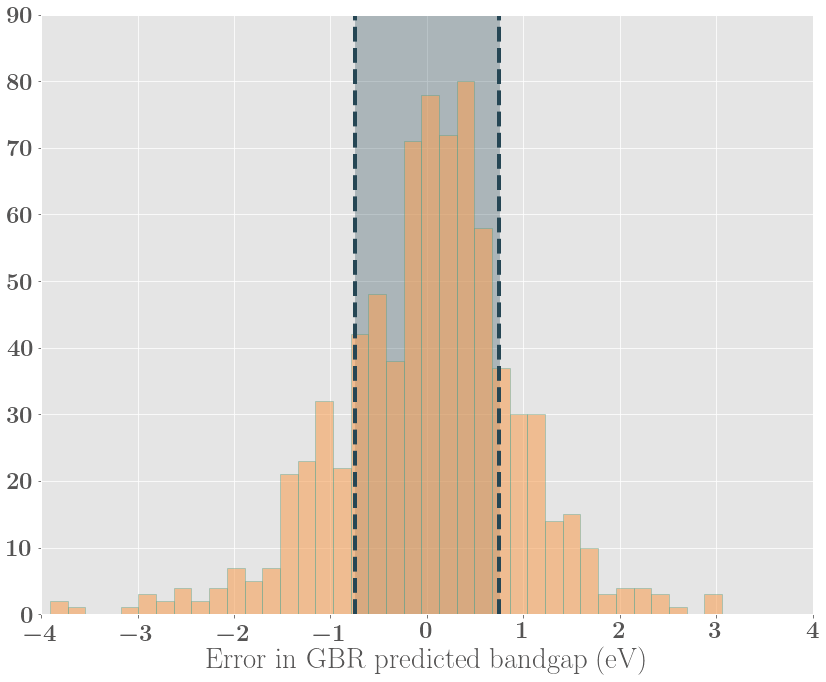

-0.008884780783018492
0.9624036287116386
0.630578640539667


In [8]:
cv_predicted = cross_val_predict(gbr, X, y, cv=crossvalidation, n_jobs=5)

x_col=y
y_col=cv_predicted
bins = 45
diffs = x_col - y_col
scale = 0.50
loc = 0.11
h = sorted(diffs)
fit = stats.logistic.pdf(h, scale  = scale, loc = loc)

# BG window
x1 = np.linspace(-0.75,0.75, 100)
y1 = stats.logistic.pdf(x1, scale  = scale, loc = loc)

#pl.plot(h,fit)
pl.hist(h,normed=False, bins = bins, 
        color = clrs[3], edgecolor = clrs[1], alpha = .6)      
pl.fill_between(x1,[90 for i in range(len(x1))], color = clrs[0],
               alpha = 0.3)

plt.xlim(-4,4)
plt.ylim(0,90)
plt.axvline(x=-0.75, ls='--', color=clrs[0])
plt.axvline(x=0.75, ls='--', color=clrs[0])
plt.xlabel('Error in GBR predicted bandgap (eV)')
plt.tight_layout()
plt.savefig('Figures/Residuals_new_2019.png', dpi = 300)
pl.show()
mu = np.average(h)
std = np.std(h)
print(mu)
print(std)

from scipy.integrate import simps
dx = x1[0]-x1[1]
area = simps(y1, dx = -dx)
print(area)

### Examine feature importances

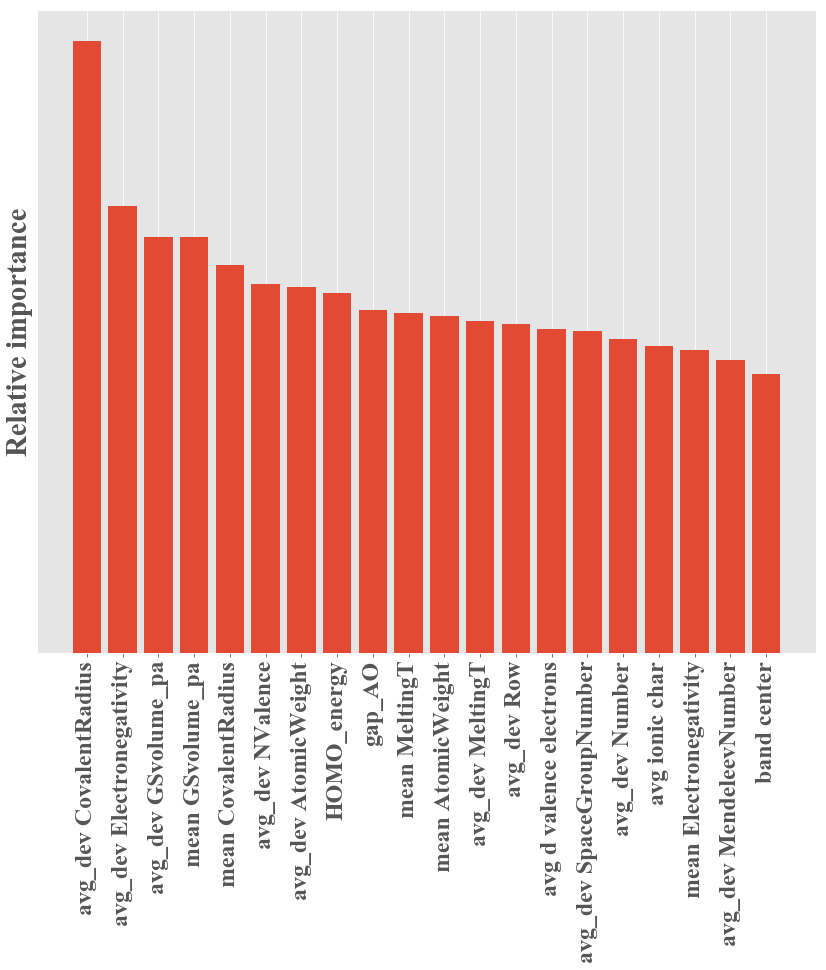

In [16]:
importances = gbr.feature_importances_
indices = np.argsort(importances)[::-1]
x_imp = [X_cols[i] for i in indices]
xtic = range(len(x_imp))
y_imp = importances[indices]

# Plot
mpl.rcParams['figure.figsize'] = (12,14)
mpl.rcParams['text.usetex'] = False
plt.bar(xtic[:20],y_imp[:20])
plt.xticks(xtic[:20], x_imp[:20], rotation = 90)
plt.yticks([])
plt.ylabel('Relative importance')
plt.tight_layout()
plt.savefig('Figures/Feature_importances_plot.png', dpi=300)
plt.show()

### Produce learning curve 
Train models with different numbers of decision trees and plots the RMSE vs number of trees. It takes a litte while to produce all the models individually, inlcuding calculating 10-fold cross-validation. 

In [ ]:
scores_train = []
scores_test = []

# Generate models 
for n_est in tqdm(range(25,2100,25)):
    gbr_model = ensemble.GradientBoostingRegressor(max_depth = 20, learning_rate = 0.01,
                                            min_samples_split = 65, min_samples_leaf = 1, 
                                            max_features = 86, subsample = 0.9, n_estimators = n_est)
    gbr_model.fit(X,y)
    y_pred = gbr_model.predict(X)
    scores_train.append(np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)))
    
    if __name__ == '__main__':
        scores = cross_val_score(gbr, X, y, scoring='neg_mean_squared_error',
                                     cv=crossvalidation, n_jobs=5)
        rmse_scores_gbr = [np.sqrt(abs(s)) for s in scores]
        scores_test.append(np.mean(np.abs(rmse_scores_gbr)))

        
# Plot
mpl.rcParams['text.usetex'] = True
plt.scatter(range(25,2100,25), scores_train, s=100, color=clrs[1], label='Training data')
plt.scatter(range(25,2100,25), scores_test, s=100, color=clrs[3], label='Test data')
plt.xlabel(r'\textbf{Model complexity (number of decision trees)}', color='#565555', labelpad=20)
plt.ylabel(r'\textbf{RMSE (eV)}', color='#565555', labelpad=20)
plt.legend()
plt.tight_layout()
plt.savefig('Figures/test_vs_train.png', dpi=300)
plt.show()

# Bandgap filtering
We now read in the new quaternary oxide compositions generated by SMACT. The code for that part of the workflow is available in the standalone [SMACT workflows repository](https://github.com/WMD-group/SMACT_workflows). We then filter the new compositions for those predicted to have bandgaps of 1.75 +/- 0.02 eV.

In [13]:
# Read in data
new_data = pd.read_csv('data/All_oxide_comps_dataframe_featurized.csv')
# drop one unnecessary column
new_data = new_data.drop(columns=['Unnamed: 0'])
new_data.describe()

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,minimum Number,maximum Number,range Number,mean Number,avg_dev Number,mode Number,minimum MendeleevNumber,maximum MendeleevNumber,range MendeleevNumber,mean MendeleevNumber,avg_dev MendeleevNumber,mode MendeleevNumber,minimum AtomicWeight,maximum AtomicWeight,range AtomicWeight,mean AtomicWeight,avg_dev AtomicWeight,mode AtomicWeight,minimum MeltingT,maximum MeltingT,range MeltingT,mean MeltingT,avg_dev MeltingT,mode MeltingT,minimum Column,maximum Column,range Column,mean Column,avg_dev Column,mode Column,minimum Row,maximum Row,range Row,mean Row,avg_dev Row,mode Row,minimum CovalentRadius,maximum CovalentRadius,range CovalentRadius,mean CovalentRadius,avg_dev CovalentRadius,mode CovalentRadius,minimum Electronegativity,maximum Electronegativity,range Electronegativity,mean Electronegativity,avg_dev Electronegativity,mode Electronegativity,minimum NsValence,maximum NsValence,range NsValence,mean NsValence,avg_dev NsValence,mode NsValence,minimum NpValence,maximum NpValence,range NpValence,mean NpValence,avg_dev NpValence,mode NpValence,minimum NdValence,maximum NdValence,range NdValence,mean NdValence,avg_dev NdValence,mode NdValence,minimum NfValence,maximum NfValence,range NfValence,mean NfValence,avg_dev NfValence,mode NfValence,minimum NValence,maximum NValence,range NValence,mean NValence,avg_dev NValence,mode NValence,minimum NsUnfilled,maximum NsUnfilled,range NsUnfilled,mean NsUnfilled,avg_dev NsUnfilled,mode NsUnfilled,minimum NpUnfilled,maximum NpUnfilled,range NpUnfilled,mean NpUnfilled,avg_dev NpUnfilled,mode NpUnfilled,minimum NdUnfilled,maximum NdUnfilled,range NdUnfilled,mean NdUnfilled,avg_dev NdUnfilled,mode NdUnfilled,minimum NfUnfilled,maximum NfUnfilled,range NfUnfilled,mean NfUnfilled,avg_dev NfUnfilled,mode NfUnfilled,minimum NUnfilled,maximum NUnfilled,range NUnfilled,mean NUnfilled,avg_dev NUnfilled,mode NUnfilled,minimum GSvolume_pa,maximum GSvolume_pa,range GSvolume_pa,mean GSvolume_pa,avg_dev GSvolume_pa,mode GSvolume_pa,minimum GSbandgap,maximum GSbandgap,range GSbandgap,mean GSbandgap,avg_dev GSbandgap,mode GSbandgap,minimum GSmagmom,maximum GSmagmom,range GSmagmom,mean GSmagmom,avg_dev GSmagmom,mode GSmagmom,minimum SpaceGroupNumber,maximum SpaceGroupNumber,range SpaceGroupNumber,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,max ionic char,avg ionic char,band center,HOMO_energy,LUMO_energy,gap_AO
count,1118505.0,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1118505.0,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1118505.0,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1118505.0,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1118505.0,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1118505.0,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1118505.0,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1118505.0,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.118505e+06,1.1

In [14]:
# Ensure new_data columns are in the same order as oxides and pick the ones to predict with
new_data = new_data.reindex(sorted(new_data.columns), axis=1)
X_cols_new_data = [c for c in new_data.columns if c not in ['task_id', 'pretty_formula', 'elements', 
                                                 'anonymous_formula','PBE_gap', 'e_above_hull', 
                                                 'oxide', 'gllbsc_gap', 'composition_obj',
                                                'HOMO_character', 'HOMO_element', 
                                                 'LUMO_character', 'LUMO_element',
                                                'avg s valence electrons']]
# Use model to predict band gaps
X = new_data.as_matrix(X_cols_new_data)
new_data['gbr_gap'] =  gbr.predict(X)

# Filter based on band gap 
# 1.75 eV lies in the centre of 1.0 - 2.5 eV (useful BG window)
useful_BGs = new_data.loc[(new_data['gbr_gap'] >= 1.73 ) & (new_data['gbr_gap'] <= 1.77)]
useful_BGs.head()

,0-norm,10-norm,2-norm,3-norm,5-norm,7-norm,HOMO_character,HOMO_element,HOMO_energy,LUMO_character,LUMO_element,LUMO_energy,avg d valence electrons,avg f valence electrons,avg ionic char,avg p valence electrons,avg s valence electrons,avg_dev AtomicWeight,avg_dev Column,avg_dev CovalentRadius,avg_dev Electronegativity,avg_dev GSbandgap,avg_dev GSmagmom,avg_dev GSvolume_pa,avg_dev MeltingT,avg_dev MendeleevNumber,avg_dev NUnfilled,avg_dev NValence,avg_dev NdUnfilled,avg_dev NdValence,avg_dev NfUnfilled,avg_dev NfValence,avg_dev NpUnfilled,avg_dev NpValence,avg_dev NsUnfilled,avg_dev NsValence,avg_dev Number,avg_dev Row,avg_dev SpaceGroupNumber,band center,composition_obj,compound possible,gap_AO,max ionic char,maximum AtomicWeight,maximum Column,maximum CovalentRadius,maximum Electronegativity,maximum GSbandgap,maximum GSmagmom,maximum GSvolume_pa,maximum MeltingT,maximum MendeleevNumber,maximum NUnfilled,maximum NValence,maximum NdUnfilled,maximum NdValence,maximum NfUnfilled,maximum NfValence,maximum NpUnfilled,maximum NpValence,maximum NsUnfilled,maximum NsValence,maximum Number,maximum Row,maximum SpaceGroupNumber,mean AtomicWeight,mean Column,mean CovalentRadius,mean Electronegativity,mean GSbandgap,mean GSmagmom,mean GSvolume_pa,mean MeltingT,mean MendeleevNumber,mean NUnfilled,mean NValence,mean NdUnfilled,mean NdValence,mean NfUnfilled,mean NfValence,mean NpUnfilled,mean NpValence,mean NsUnfilled,mean NsValence,mean Number,mean Row,mean SpaceGroupNumber,minimum AtomicWeight,minimum Column,minimum CovalentRadius,minimum Electronegativity,minimum GSbandgap,minimum GSmagmom,minimum GSvolume_pa,minimum MeltingT,minimum MendeleevNumber,minimum NUnfilled,minimum NValence,minimum NdUnfilled,minimum NdValence,minimum NfUnfilled,minimum NfValence,minimum NpUnfilled,minimum NpValence,minimum NsUnfilled,minimum NsValence,minimum Number,minimum Row,minimum SpaceGroupNumber,mode AtomicWeight,mode Column,mode CovalentRadius,mode Electronegativity,mode GSbandgap,mode GSmagmom,mode GSvolume_pa,mode MeltingT,mode MendeleevNumber,mode NUnfilled,mode NValence,mode NdUnfilled,mode NdValence,mode NfUnfilled,mode NfValence,mode NpUnfilled,mode NpValence,mode NsUnfilled,mode NsValence,mode Number,mode Row,mode SpaceGroupNumber,pretty_formula,range AtomicWeight,range Column,range CovalentRadius,range Electronegativity,range GSbandgap,range GSmagmom,range GSvolume_pa,range MeltingT,range MendeleevNumber,range NUnfilled,range NValence,range NdUnfilled,range NdValence,range NfUnfilled,range NfValence,range NpUnfilled,range NpValence,range NsUnfilled,range NsValence,range Number,range Row,range SpaceGroupNumber,gbr_gap
0,4,0.625000,0.661438,0.629961,0.625120,0.625003,d,Mo,-0.153347,d,Mo,-0.153347,5.625000,0.000000,0.045047,1.625000,1.375000,17.658844,4.843750,24.375000,0.385937,0.423000,0.000000,4.915312,1230.218750,18.90625,2.031250,3.937500,2.343750,2.187500,0.0,0.000000,0.781250,2.031250,0.468750,0.468750,7.656250,0.781250,93.281250,-2.431265,Mo5 Se1 Br1 O1,False,0.0,0.336084,95.960000,17.0,154.0,3.44,1.457,0.000000,29.480,2896.0,95.0,6.0,17.0,5.0,10.0,0.0,0.0,2.0,5.0,1.0,2.0,42.0,5.0,229.0,81.832925,9.875000,134.500000,2.468750,0.282000,0.000000,17.869375,1911.825000,65.125000,4.375000,8.625000,3.125000,5.625000,0.0,0.000000,0.625000,1.625000,0.625000,1.375000,35.875000,4.375000,154.375000,15.9994,6.0,66.0,2.16,0.0,0.0,9.105,54.8,50.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,12.0,95.9600,6.0,154.0,2.16,0.0,0.0,15.690000,2896.00,50.0,6.0,6.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,42.0,5.0,229.0,Mo5SeBrO,79.960600,11.0,88.0,1.28,1.457,0.000000,20.375,2841.2,45.0,5.0,11.0,5.0,10.0,0.0,0.0,2.0,5.0,1.0,1.0,34.0,3.0,217.0,1.742747
190,4,0.625000,0.661438,0.629961,0.625120,0.625003,p,Ge,-0.149882,p,Ge,-0.149882,2.375000,1.750000,0.117038,0.750000,1.250000,47.029225,5.781250,13.625000,0.748437,0.083781,0.000000,2.099792,464.696875,35.31250,0.781250,6.437500,0.218750,3.562500,0.0,3.062500,1.125000,1.125000,0.375000,0.375000,19.187500,1.125000,47.218750

In [15]:
useful_BGs.describe()

,0-norm,10-norm,2-norm,3-norm,5-norm,7-norm,HOMO_energy,LUMO_energy,avg d valence electrons,avg f valence electrons,avg ionic char,avg p valence electrons,avg s valence electrons,avg_dev AtomicWeight,avg_dev Column,avg_dev CovalentRadius,avg_dev Electronegativity,avg_dev GSbandgap,avg_dev GSmagmom,avg_dev GSvolume_pa,avg_dev MeltingT,avg_dev MendeleevNumber,avg_dev NUnfilled,avg_dev NValence,avg_dev NdUnfilled,avg_dev NdValence,avg_dev NfUnfilled,avg_dev NfValence,avg_dev NpUnfilled,avg_dev NpValence,avg_dev NsUnfilled,avg_dev NsValence,avg_dev Number,avg_dev Row,avg_dev SpaceGroupNumber,band center,gap_AO,max ionic char,maximum AtomicWeight,maximum Column,maximum CovalentRadius,maximum Electronegativity,maximum GSbandgap,maximum GSmagmom,maximum GSvolume_pa,maximum MeltingT,maximum MendeleevNumber,maximum NUnfilled,maximum NValence,maximum NdUnfilled,maximum NdValence,maximum NfUnfilled,maximum NfValence,maximum NpUnfilled,maximum NpValence,maximum NsUnfilled,maximum NsValence,maximum Number,maximum Row,maximum SpaceGroupNumber,mean AtomicWeight,mean Column,mean CovalentRadius,mean Electronegativity,mean GSbandgap,mean GSmagmom,mean GSvolume_pa,mean MeltingT,mean MendeleevNumber,mean NUnfilled,mean NValence,mean NdUnfilled,mean NdValence,mean NfUnfilled,mean NfValence,mean NpUnfilled,mean NpValence,mean NsUnfilled,mean NsValence,mean Number,mean Row,mean SpaceGroupNumber,minimum AtomicWeight,minimum Column,minimum CovalentRadius,minimum Electronegativity,minimum GSbandgap,minimum GSmagmom,minimum GSvolume_pa,minimum MeltingT,minimum MendeleevNumber,minimum NUnfilled,minimum NValence,minimum NdUnfilled,minimum NdValence,minimum NfUnfilled,minimum NfValence,minimum NpUnfilled,minimum NpValence,minimum NsUnfilled,minimum NsValence,minimum Number,minimum Row,minimum SpaceGroupNumber,mode AtomicWeight,mode Column,mode CovalentRadius,mode Electronegativity,mode GSbandgap,mode GSmagmom,mode GSvolume_pa,mode MeltingT,mode MendeleevNumber,mode NUnfilled,mode NValence,mode NdUnfilled,mode NdValence,mode NfUnfilled,mode NfValence,mode NpUnfilled,mode NpValence,mode NsUnfilled,mode NsValence,mode Number,mode Row,mode SpaceGroupNumber,range AtomicWeight,range Column,range CovalentRadius,range Electronegativity,range GSbandgap,range GSmagmom,range GSvolume_pa,range MeltingT,range MendeleevNumber,range NUnfilled,range NValence,range NdUnfilled,range NdValence,range NfUnfilled,range NfValence,range NpUnfilled,range NpValence,range NsUnfilled,range NsValence,range Number,range Row,range SpaceGroupNumber,gbr_gap
count,19151.0,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.00000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.0,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.0,19151.0,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.0,19151.0,19151.0,19151.0,19151.000000,19151.000000,19151.0,19151.000000,19151.000000,19151.0,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000000,19151.000

A dataframe of this format is used in the following notebook for further data-driven screening.